https://medium.com/@ggarkoti02/advanced-exploratory-data-analysis-master-advanced-eda-techniques-with-python-d9642b5bd4f2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load your dataset
df = pd.read_csv('./data/regression_bonus_practice_data.csv')

In [3]:
# Function for advanced univariate analysis
def advanced_univariate_analysis(df):
    """
    Perform comprehensive univariate analysis on numerical columns
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Create a summary statistics dataframe
    summary_stats = pd.DataFrame()
    
    for col in numeric_cols:
        summary_stats[col] = {
            'Count': df[col].count(),
            'Mean': df[col].mean(),
            'Median': df[col].median(),
            'Std Dev': df[col].std(),
            'Min': df[col].min(),
            'Q1': df[col].quantile(0.25),
            'Q3': df[col].quantile(0.75),
            'Max': df[col].max(),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurtosis(),
            'Variance': df[col].var(),
            'Range': df[col].max() - df[col].min(),
            'CV': df[col].std() / df[col].mean() if df[col].mean() != 0 else np.nan
        }
    
    return summary_stats.T

In [4]:
# Execute analysis
summary = advanced_univariate_analysis(df)
print("Advanced Univariate Statistics:")
print(summary.head(10))
# Test for normality
print("\n" + "="*70)
print("NORMALITY TESTS")
print("="*70)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols[:5]:  # Test first 5 columns
    # Shapiro-Wilk test
    stat_sw, p_value_sw = stats.shapiro(df[col].dropna())
    
    # Anderson-Darling test
    result_ad = stats.anderson(df[col].dropna())
    
    # D'Agostino-Pearson test
    stat_dp, p_value_dp = stats.normaltest(df[col].dropna())
    
    print(f"\n{col}:")
    print(f"  Shapiro-Wilk: statistic={stat_sw:.4f}, p-value={p_value_sw:.4f}")
    print(f"  Anderson-Darling: statistic={result_ad.statistic:.4f}")
    print(f"  D'Agostino-Pearson: statistic={stat_dp:.4f}, p-value={p_value_dp:.4f}")
    
    # Interpretation
    if p_value_sw > 0.05:
        print(f"  ✓ {col} appears normally distributed (p > 0.05)")
    else:
        print(f"  ✗ {col} is NOT normally distributed (p < 0.05)")


Advanced Univariate Statistics:
                      Count         Mean  Median      Std Dev   Min       Q1  \
index               15900.0  7949.500000  7949.5  4590.078975   0.0  3974.75   
number_of_siblings  15900.0     0.886541     1.0     0.751346   0.0     0.00   
final_test          15405.0    67.165401    68.0    13.977879  32.0    56.00   
n_male              15900.0    13.880000    14.0     6.552584   0.0    10.00   
n_female            15900.0     8.906038     8.0     6.663852   0.0     4.00   
age                 15900.0    15.213459    15.0     1.758941  -5.0    15.00   
hours_per_week      15900.0    10.312579     9.0     4.461861   0.0     7.00   
attendance_rate     15122.0    93.270268    95.0     7.984230  40.0    92.00   

                          Q3      Max     IQR  Skewness   Kurtosis  \
index               11924.25  15899.0  7949.5  0.000000  -1.200000   
number_of_siblings      1.00      2.0     1.0  0.188977  -1.211288   
final_test             78.00    100.0

/home/dingaroo/anaconda3/envs/aiap21/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15900.
  res = hypotest_fun_out(*samples, **kwds)
/home/dingaroo/anaconda3/envs/aiap21/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15405.
  res = hypotest_fun_out(*samples, **kwds)


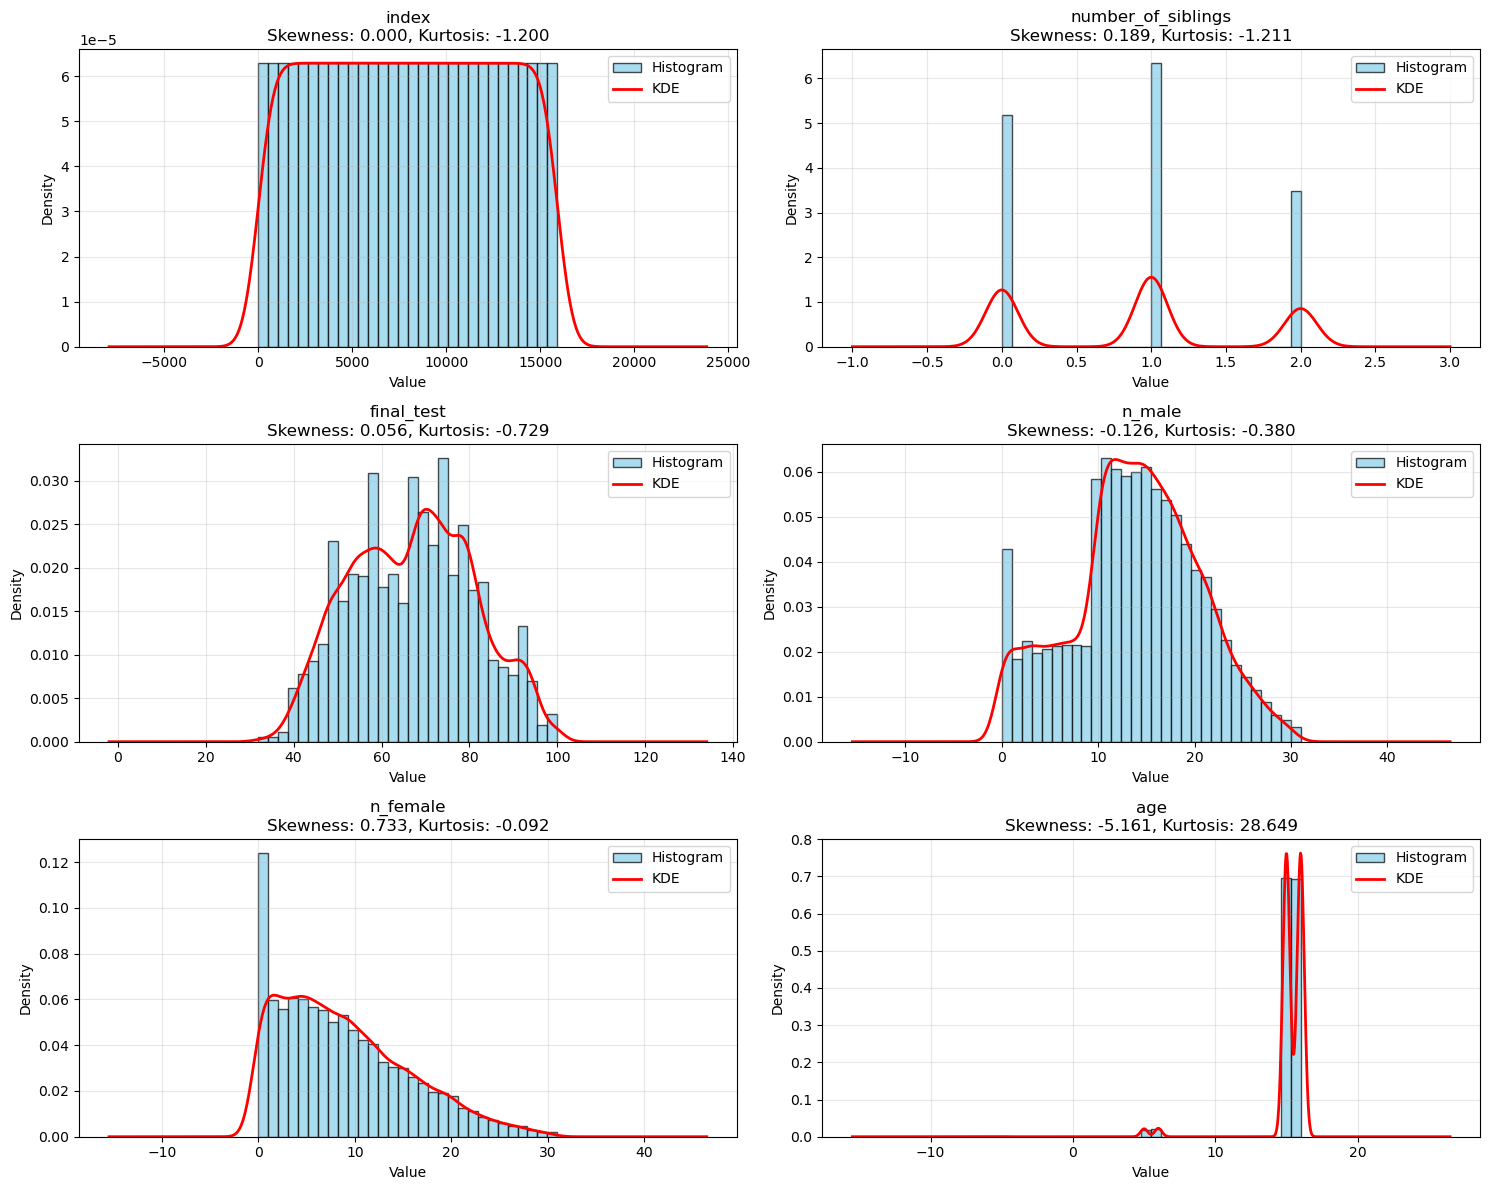


✓ Univariate analysis complete! Distribution plots saved.


In [5]:
# Visualize distributions with advanced plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()
for idx, col in enumerate(numeric_cols[:6]):
    # Histogram with KDE
    axes[idx].hist(df[col].dropna(), bins=30, density=True, alpha=0.7, 
                   color='skyblue', edgecolor='black', label='Histogram')
    
    # Overlay KDE
    df[col].dropna().plot(kind='kde', ax=axes[idx], color='red', 
                          linewidth=2, label='KDE', secondary_y=False)
    
    # Add statistics to plot
    skewness = df[col].skew()
    kurtosis = df[col].kurtosis()
    axes[idx].set_title(f'{col}\nSkewness: {skewness:.3f}, Kurtosis: {kurtosis:.3f}')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/univariate_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Univariate analysis complete! Distribution plots saved.")

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [7]:
def detect_outliers_multiple_methods(df, numeric_cols=None):
    """
    Detect outliers using 5 different methods and compare results
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Prepare data
    data = df[numeric_cols].copy()
    data_clean = data.dropna()
    
    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_clean)
    
    # Method 1: Z-Score (Statistical)
    z_scores = np.abs(stats.zscore(scaled_data))
    # z_scores = np.abs(stats.zscore(scaled_data))
    outliers_zscore = (z_scores > 3).any(axis=1)
    
    # Method 2: IQR (Statistical)
    Q1 = data_clean.quantile(0.25)
    Q3 = data_clean.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = ((data_clean < (Q1 - 1.5 * IQR)) | 
                    (data_clean > (Q3 + 1.5 * IQR))).any(axis=1)
    
    # Method 3: Isolation Forest (Model-based)
    iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
    outliers_if = iso_forest.fit_predict(scaled_data) == -1
    
    # Method 4: Local Outlier Factor (Density-based)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    outliers_lof = lof.fit_predict(scaled_data) == -1
    
    # Method 5: Mahalanobis Distance
    try:
        ee = EllipticEnvelope(contamination=0.05, random_state=42)
        outliers_ee = ee.fit_predict(scaled_data) == -1
    except:
        outliers_ee = np.zeros(len(scaled_data), dtype=bool)
    
    # Create results dataframe
    results = pd.DataFrame({
        'Z-Score': outliers_zscore,
        'IQR': outliers_iqr,
        'Isolation Forest': outliers_if,
        'LOF': outliers_lof,
        'Elliptic Envelope': outliers_ee
    }, index=data_clean.index)
    
    # Count outliers detected by each method
    print("Outliers Detected by Each Method:")
    print(results.sum())
    print(f"\nTotal samples: {len(data_clean)}")
    
    # Find consensus outliers (detected by at least 3 methods)
    consensus_outliers = (results.sum(axis=1) >= 3)
    print(f"\nConsensus outliers (≥3 methods): {consensus_outliers.sum()}")
    
    return results, consensus_outliers

In [8]:
# Execute outlier detection
outlier_results, consensus = detect_outliers_multiple_methods(df)

Outliers Detected by Each Method:
Z-Score               981
IQR                  1373
Isolation Forest      733
LOF                   733
Elliptic Envelope     733
dtype: int64

Total samples: 14648

Consensus outliers (≥3 methods): 838


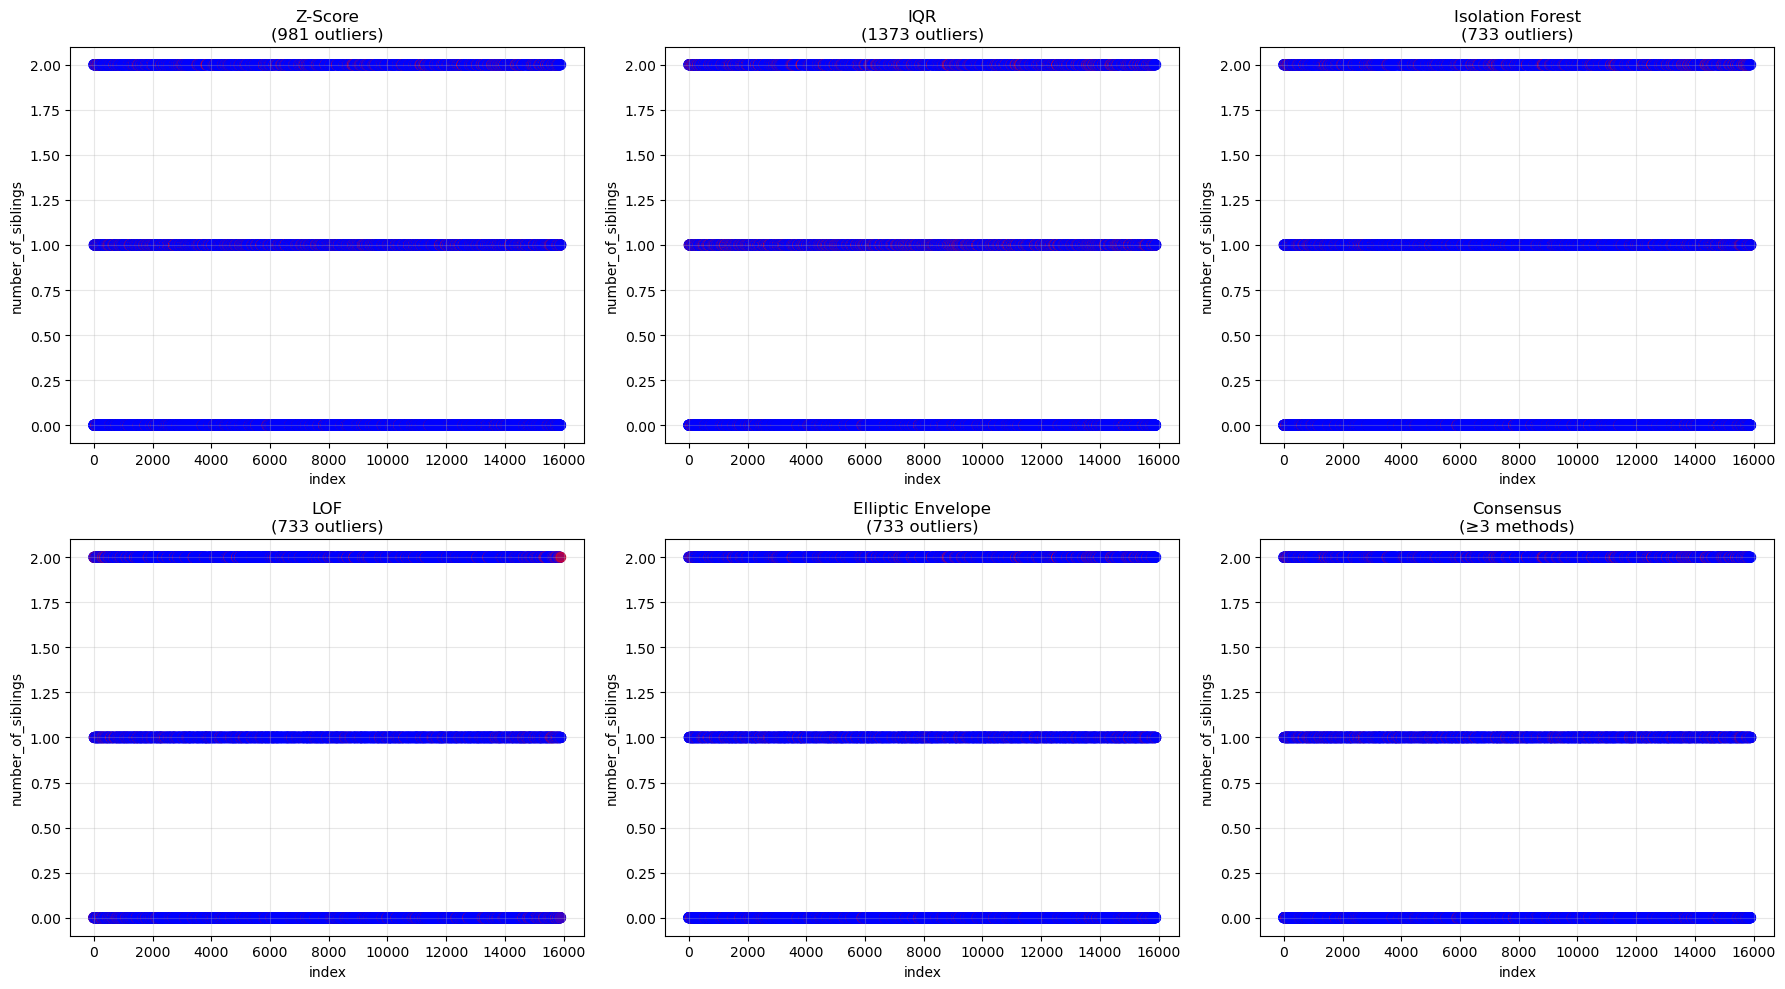


✓ Outlier detection comparison complete!


In [9]:
# Visualize outlier detection results
numeric_cols = df.select_dtypes(include=[np.number]).columns[:2]
# Use the same indices as outlier_results to ensure alignment
X = df.loc[outlier_results.index, numeric_cols].values
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
methods = ['Z-Score', 'IQR', 'Isolation Forest', 'LOF', 'Elliptic Envelope', 'Consensus']
for idx, method in enumerate(methods):
    ax = axes[idx]
    
    if method == 'Consensus':
        colors = np.where(consensus.values, 'red', 'blue')
        title_text = f'{method}\n(≥3 methods)'
        outlier_count = consensus.sum()
    else:
        colors = np.where(outlier_results[method].values, 'red', 'blue')
        outlier_count = outlier_results[method].sum()
        title_text = f'{method}\n({outlier_count} outliers)'
    
    ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6, s=50)
    ax.set_xlabel(numeric_cols[0])
    ax.set_ylabel(numeric_cols[1])
    ax.set_title(title_text)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outlier_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Outlier detection comparison complete!")

In [10]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
def advanced_correlation_analysis(df):
    """
    Perform comprehensive correlation analysis with multiple methods
    """
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Method 1: Pearson Correlation (Linear relationships)
    pearson_corr = numeric_df.corr(method='pearson')
    
    # Method 2: Spearman Correlation (Rank-based, robust to outliers)
    spearman_corr = numeric_df.corr(method='spearman')
    
    # Method 3: Kendall Correlation (Ordinal data)
    kendall_corr = numeric_df.corr(method='kendall')
    
    return pearson_corr, spearman_corr, kendall_corr

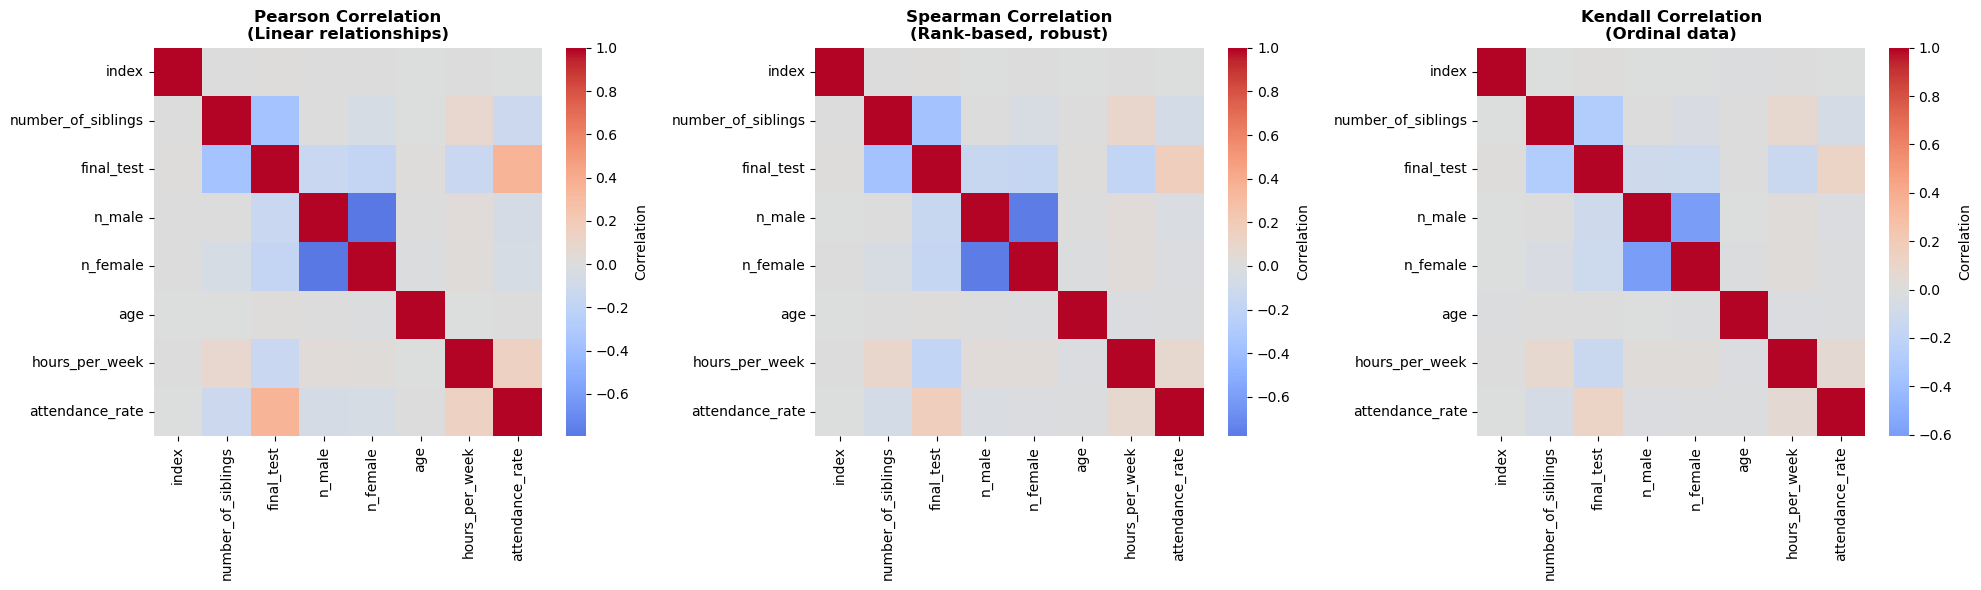


Top 10 Correlated Pairs (Pearson):
                  Var1             Var2   Pearson  Spearman   Kendall
18              n_male         n_female -0.795446 -0.780911 -0.606562
7   number_of_siblings       final_test -0.363767 -0.369936 -0.283686
17          final_test  attendance_rate  0.349375  0.168694  0.118264
14          final_test         n_female -0.171978 -0.161848 -0.111938
13          final_test           n_male -0.149152 -0.152408 -0.105026
16          final_test   hours_per_week -0.148254 -0.180432 -0.130791
27      hours_per_week  attendance_rate  0.143873  0.078774  0.056699
12  number_of_siblings  attendance_rate -0.122420 -0.071441 -0.057341
11  number_of_siblings   hours_per_week  0.085327  0.092962  0.073897
21              n_male  attendance_rate -0.053788 -0.024977 -0.017688


In [12]:
# Execute correlation analysis
pearson_corr, spearman_corr, kendall_corr = advanced_correlation_analysis(df)
# Visualize correlation comparisons
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# Pearson
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', center=0, 
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Pearson Correlation\n(Linear relationships)', fontsize=12, fontweight='bold')
# Spearman
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', center=0, 
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Spearman Correlation\n(Rank-based, robust)', fontsize=12, fontweight='bold')
# Kendall
sns.heatmap(kendall_corr, annot=False, cmap='coolwarm', center=0, 
            ax=axes[2], cbar_kws={'label': 'Correlation'})
axes[2].set_title('Kendall Correlation\n(Ordinal data)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
# Find top correlated pairs
print("\nTop 10 Correlated Pairs (Pearson):")
print("="*60)
# Get correlation pairs
corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i+1, len(pearson_corr.columns)):
        corr_pairs.append({
            'Var1': pearson_corr.columns[i],
            'Var2': pearson_corr.columns[j],
            'Pearson': pearson_corr.iloc[i, j],
            'Spearman': spearman_corr.iloc[i, j],
            'Kendall': kendall_corr.iloc[i, j]
        })
corr_df = pd.DataFrame(corr_pairs).sort_values('Pearson', key=abs, ascending=False)
print(corr_df.head(10).to_string())


In [13]:
def calculate_vif(df):
    """
    Calculate VIF for all features to detect multicollinearity
    """
    numeric_df = df.select_dtypes(include=[np.number]).drop(
        columns=['Target'], errors='ignore')
    
    # Remove rows with NaN or infinite values
    numeric_df = numeric_df.dropna()
    numeric_df = numeric_df[~np.isinf(numeric_df).any(axis=1)]
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_df.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) 
                       for i in range(numeric_df.shape[1])]
    
    return vif_data.sort_values('VIF', ascending=False)

In [14]:
# Multicollinearity Detection using VIF
print("\n\nVariance Inflation Factor (VIF) Analysis:")
print("="*60)
vif_results = calculate_vif(df)
print(vif_results.to_string())



Variance Inflation Factor (VIF) Analysis:
              Feature         VIF
7     attendance_rate  114.445943
5                 age   58.019193
2          final_test   38.980260
3              n_male   14.749403
4            n_female    7.741796
6      hours_per_week    6.788162
0               index    3.950215
1  number_of_siblings    2.720508


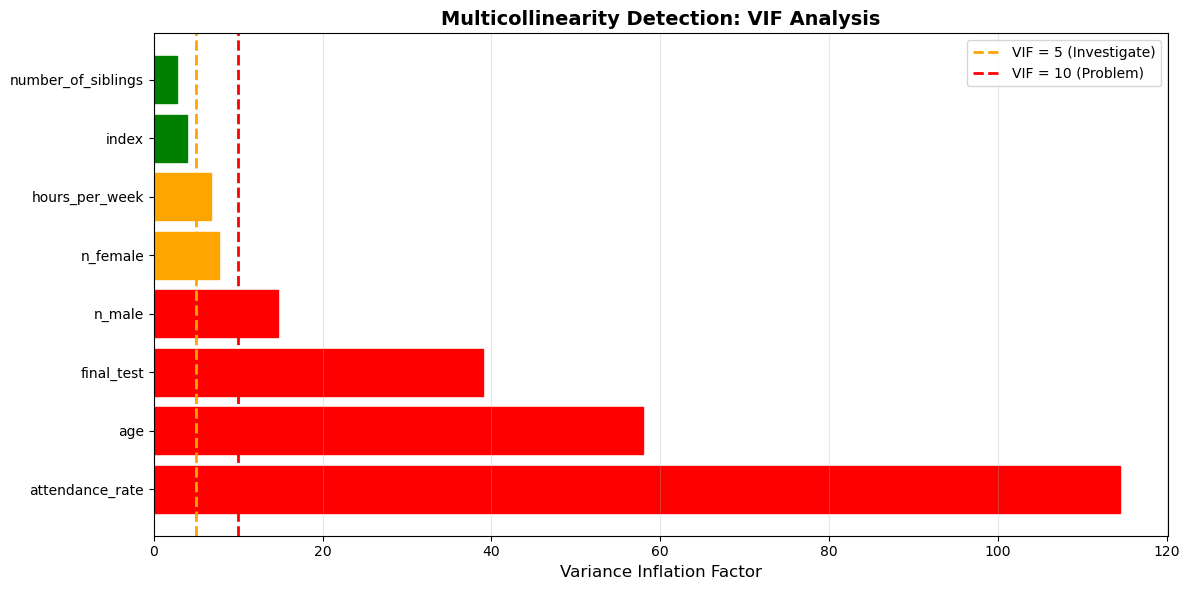


✓ Correlation and multicollinearity analysis complete!


In [15]:
# Visualize VIF
plt.figure(figsize=(12, 6))
bars = plt.barh(vif_results['Feature'], vif_results['VIF'], color='steelblue')
# Add threshold lines
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Investigate)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (Problem)')
# Color code bars based on VIF value
for i, (idx, row) in enumerate(vif_results.iterrows()):
    if row['VIF'] > 10:
        bars[i].set_color('red')
    elif row['VIF'] > 5:
        bars[i].set_color('orange')
    else:
        bars[i].set_color('green')
plt.xlabel('Variance Inflation Factor', fontsize=12)
plt.title('Multicollinearity Detection: VIF Analysis', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('vif_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Correlation and multicollinearity analysis complete!")

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

/home/dingaroo/anaconda3/envs/aiap21/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def dimensionality_reduction_analysis(df):
    """
    Apply multiple dimensionality reduction techniques
    """
    # Prepare data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    data = df[numeric_cols].dropna()
    
    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # 1. PCA Analysis
    print("Performing PCA...")
    pca_full = PCA()
    pca_full.fit(scaled_data)
    
    # Calculate cumulative explained variance
    cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
    
    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
    
    print(f"Number of components for 95% variance: {n_components_95}")
    print(f"Total features: {len(numeric_cols)}")
    print(f"Reduction ratio: {(1 - n_components_95/len(numeric_cols))*100:.1f}%")
    
    # Apply PCA with optimal components
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    # 2. t-SNE Analysis
    print("\nPerforming t-SNE (this may take a moment)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    tsne_data = tsne.fit_transform(scaled_data)
    
    # 3. UMAP Analysis
    print("Performing UMAP...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    umap_data = umap_reducer.fit_transform(scaled_data)
    
    return {
        'pca': pca,
        'pca_data': pca_data,
        'pca_full': pca_full,
        'tsne_data': tsne_data,
        'umap_data': umap_data,
        'scaled_data': scaled_data,
        'cumsum_var': cumsum_var
    }

In [18]:
# Execute dimensionality reduction
dim_red_results = dimensionality_reduction_analysis(df)

Performing PCA...
Number of components for 95% variance: 7
Total features: 8
Reduction ratio: 12.5%

Performing t-SNE (this may take a moment)...
Performing UMAP...
Performing UMAP...


/home/dingaroo/anaconda3/envs/aiap21/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: 'c' argument has 15900 elements, which is inconsistent with 'x' and 'y' with size 14648.

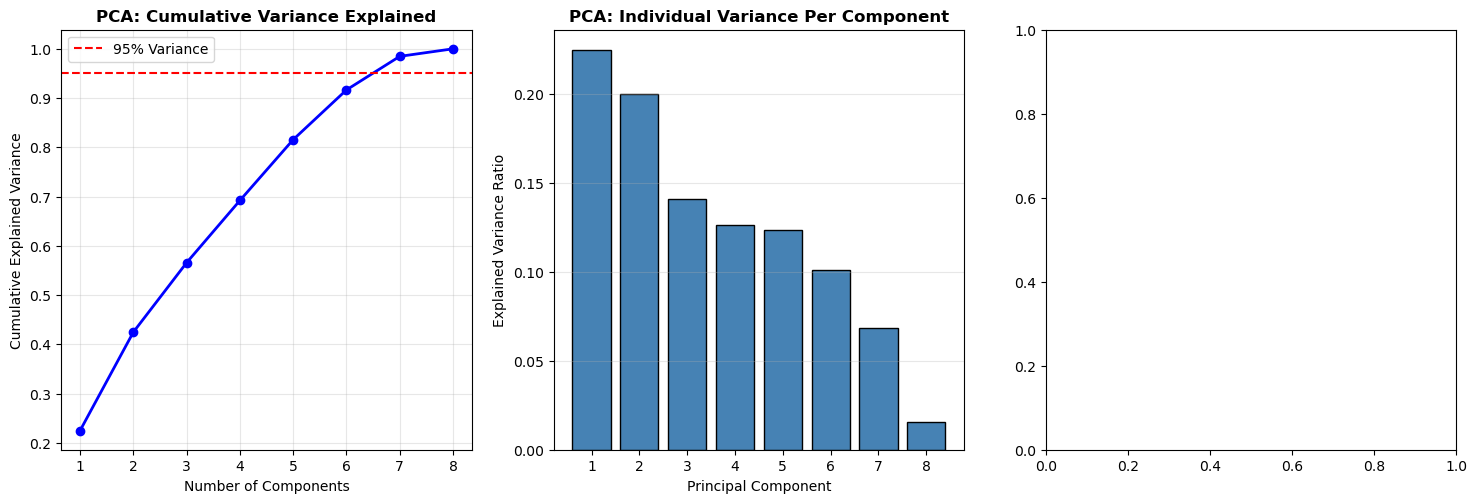

In [19]:
# Visualize results
fig = plt.figure(figsize=(18, 12))
# 1. PCA Explained Variance
ax1 = plt.subplot(2, 3, 1)
n_components = len(dim_red_results['cumsum_var'])
ax1.plot(range(1, n_components + 1), dim_red_results['cumsum_var'], 'bo-', linewidth=2)
ax1.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_title('PCA: Cumulative Variance Explained', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()
# 2. Individual Variance per Component
ax2 = plt.subplot(2, 3, 2)
ax2.bar(range(1, min(11, n_components + 1)), 
        dim_red_results['pca_full'].explained_variance_ratio_[:10], 
        color='steelblue', edgecolor='black')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('PCA: Individual Variance Per Component', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
# 3. PCA 2D Projection
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(dim_red_results['pca_data'][:, 0], 
                      dim_red_results['pca_data'][:, 1], 
                      c=df['final_test'].values, cmap='viridis', alpha=0.6, s=50)
ax3.set_xlabel(f"PC1 ({dim_red_results['pca'].explained_variance_ratio_:.2%})")
ax3.set_ylabel(f"PC2 ({dim_red_results['pca'].explained_variance_ratio_:.2%})")
ax3.set_title('PCA: 2D Projection', fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='final_test')
ax3.grid(alpha=0.3)
# 4. t-SNE Projection
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(dim_red_results['tsne_data'][:, 0], 
                      dim_red_results['tsne_data'][:, 1], 
                      c=df['final_test'].values, cmap='viridis', alpha=0.6, s=50)
ax4.set_xlabel('t-SNE Dimension 1')
ax4.set_ylabel('t-SNE Dimension 2')
ax4.set_title('t-SNE: Non-linear Dimensionality Reduction', fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='final_test')
ax4.grid(alpha=0.3)
# 5. UMAP Projection
ax5 = plt.subplot(2, 3, 5)
scatter = ax5.scatter(dim_red_results['umap_data'][:, 0], 
                      dim_red_results['umap_data'][:, 1], 
                      c=df['final_test'].values, cmap='viridis', alpha=0.6, s=50)
ax5.set_xlabel('UMAP Dimension 1')
ax5.set_ylabel('UMAP Dimension 2')
ax5.set_title('UMAP: Fast Non-linear Reduction', fontweight='bold')
plt.colorbar(scatter, ax=ax5, label='final_test')
ax5.grid(alpha=0.3)
# 6. Comparison (PCA vs UMAP)
ax6 = plt.subplot(2, 3, 6)
ax6.scatter(dim_red_results['pca_data'][:, 0], dim_red_results['pca_data'][:, 1], 
            alpha=0.5, s=30, label='PCA', color='blue')
ax6.scatter(dim_red_results['umap_data'][:, 0], dim_red_results['umap_data'][:, 1], 
            alpha=0.5, s=30, label='UMAP', color='red')
ax6.set_xlabel('Dimension 1')
ax6.set_ylabel('Dimension 2')
ax6.set_title('Method Comparison: PCA vs UMAP', fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/dimensionality_reduction.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Dimensionality reduction analysis complete!")